<a href="https://colab.research.google.com/github/brunobro/decomposicao-em-valores-singulares-em-multirresolucao/blob/main/MI_MRSVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Decomposição em Valores Singulares em Multirresolução (MRSVD - Multiresolution Singular Value Decomposition)**

<u>Método proposto por Kakarala e Ogunbona (2001):</u> Signal analysis using a multiresolution form of the singular value decomposition. IEEE Transactions on Image processing, 10(5), 724-735.

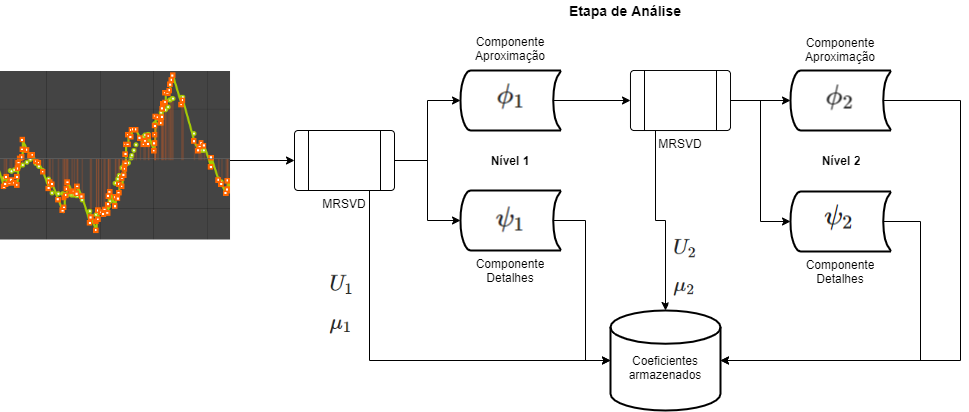

**Descrição matemática do método (algoritmo):**

**<u>Etapa de Análise (Decomposição)</u>**

Considera-se $L$ níveis de decomposição e o sinal $y(t)$. O comprimento $N$ do sinal deve ser divisível por $2^L$.

**0.** Toma-se $\phi_0(t)=y(t)$; 

**1.** Enquanto $l=1,2,\ldots,L$, faça $N_l=N/2^l$


**1.1** Obtenha uma matriz $Y_l$ cuja primeira linha correspondente as amostras pares de $\phi_{(l-1)}$ e a segunda linha as amostras ímpares de $\phi_{(l-1)}$ (sinal no nível $l$ de decomposição):

$$
Y_l = \left[\begin{matrix}\phi_{(l-1)}(2)&\phi_{(l-1)}(4)&\phi_{(l-1)}(6)&\phi_{(l-1)}(8)&...&\phi_{(l-1)}(2N_l)\\\phi_{(l-1)}(1)&\phi_{(l-1)}(3)&\phi_{(l-1)}(5)&\phi_{(l-1)}(7)&...&\phi_{(l-1)}(2N_l-1)\end{matrix} \right]
$$

**1.2** Remova a média de $Y_l$, obtendo

$$
{\bar{Y}}_l=Y_lH_{N_l}
$$

onde $H_{N_l}=I_{N_l}-\frac{1}{{N_l}}e_Ne_{N_l}^T$ é uma matriz idempotente (i.e. $H_{N_l} H_{N_l} = H_{N_l}$).


**1.3** Computar a Decomposição em Valores Singulares )(SVD) de ${\bar{Y}}_l$ para obter o filtro de descorreção $U_l$:

$$
{\bar{Y}}_l=U_l S_l V_l^T
$$

**1.4** Aplique o filtro $U_l$ na matriz com média removida, obtendo:

$$
{\widetilde{Y}}_l=U_l^T{\bar{Y}}_l
$$

**1.5** Obtenha as componentes de aproximação $\phi_l$ e detalhes $\psi_l$:

$$
\phi_l={\widetilde{Y}}_l\left(1,\cdot\right)
$$

$$
\psi_l={\widetilde{Y}}_l\left(2,\cdot\right)
$$

Ao final da aplicação dos $L$ passos temos a seguinte transformação:
$$
y → \left\lbrace \phi_L,\ \left\{\psi_l\right\}_{l=1}^L,\left\{U_l\right\}_{l=1}^L \right\rbrace
$$
Observe que são armazenados todos as componentes de detalhes e as matrizes de filtro, mas apenas a última componente de aproximação.

**<u>Observação:</u>**
Na prática também é necessário armazenar os vetores médios $\left\lbrace \mu_l \right\rbrace_{l=1}^{L}$, tal que 
$$\mu_l = Y_l e_{N_l} / N_l$$
para implementar a síntese. Essa abordagem evita ter que calcular a invesar da matriz $H_{N_l}$, que pode ser não-invertível em cartas situações.

**<u>Etapa de Síntese (Reconstrução)</u>**

**1.** Enquanto $q=L,L-1,\ldots,1$

**1.1** Forme a matriz com as componentes de aproximação e detalhes

$$
\tilde{Y}_q = \left[ \begin{matrix} \phi_q \\ \psi_q\end{matrix}\right]
$$

**1.2** Aplique o filtro de descorrelação a matriz $\tilde{Y}_q$

$$
\bar{Y}_q = U_{q}^{T} \tilde{Y}_q
$$

**1.3** Adicione o vetor médio a matriz $\bar{Y}_q$ obtendo a matriz original

$$
Y_q = \bar{Y}_q + \mu_q
$$

**1.4** Reconstrua o sinal no nível $q$

$$
\phi_{q - 1} = \left[ \begin{matrix} Y_q(1,1) & Y_q(2,1) & Y_q(1,2) & ⋯ & Y_q(1,2N_q) & Y_q(2,2N_q) \end{matrix}\right]
$$

**Nível máximo de decomposição**

Como o comprimento $N$ do sinal deve ser divisível por $2^L$, onde $L$ é o nível máximo de decomposição, então temos que

$$
L = \log_2(N) - 1
$$

O $-1$ é inserido porque no último nível há apenas amostras nulas.

**Observações importantes**

* No nível $l$ de decomposição, o sinal analisado possui $N/2^l$ amostras, ou seja, a cada nível o sinal possui metade das amostras do nível anterior, onde $N$ é o comprimento do sinal.

* A remoção da média é opcional (${\bar{Y}}_l=Y_lH_{N_l}$). Entretando, sem remover a média não se pode garantir que as componentes de aproximação e detalhes estejam descorrelacionadas. Por outro lado, não remover a média garante que haverá conservação de energia de um nível para outro.

* A decomposição aqui apresentada é chamada de **Diádica**, pelo motivo acima exposto. Entretanto, ela pode ser $p$-ádica, onde a cada novo nível, $N/p^l$ amostras estão disponíveis para análise. Neste caso, $L = \log_{p}(N) - 1$.

# **Script Python MRSVD**

In [36]:
import numpy as np

'''
Multiresolution Singular Value Decomposition (MRSVD)
'''
class MRSVD: 

    '''
    Método para decomposição (análise) do sinal
    '''    
    def dec(self, phi, level_dec = None, mean_removal = True):

        #Fixa se a remoção da média será aplicada
        self.mean_removal = mean_removal
            
        #armazenas as componentes em todos os níveis
        PHIs = []
        PSIs = []
        Us   = []
        Ss   = []
        MUs  = []

        #define o nível de decomposição        
        if level_dec == None:
            level_dec = self.levelmax(phi)
        else:
            self.max_level = level_dec
        
        #comprimento do sinal
        N = len(phi)

        #realiza a decomposição
        for l in range(1, level_dec + 1):
            M  = len(phi)
            Nl = N/(2**l)

            #Separa as amostras pelos índices                
            even = phi[0:M:2]
            odd  = phi[1:M:2]

            #Cria um nova matriz, onde a primeira linha tem as amostras de índice par
            #e a segunda as de índice ímpar
            Y = np.vstack((even , odd))

            #Remove a média da matriz Y
            if self.mean_removal:
                #Obtém a matriz média
                H, e = self.Hn(N, l)
                Mu   = np.dot(Y, e) / Nl
                Ybar = np.dot(Y, H)
            else:
                Ybar = Y

            #Aplica a SVD o obtém a matriz filtro U e os valores singulares
            U, S, _ = np.linalg.svd(Ybar, full_matrices=True)

            #IMPORTTANTE: a matriz filtro aqui foi multiplicada por -1 para evitar
            #inversão dos sinais (defasagem de 180º). Isso não afeta sua ortogonalidade
            U = -U

            #Para o último nível de decomposição
            if len(S) == 1:
                S = [S, 0]
            
            #Aplica o filtro de descorrelação, para obtenção das componentes ortogonais
            Ytilde = np.dot(U.T , Ybar)
            
            #Componentes de aproximação e detalhes
            phi = Ytilde[0]
            psi = Ytilde[1]

            #Armazena todos os coeficientes necessários para a reconstrução do sinal            
            PHIs.append(phi)
            PSIs.append(psi)
            Us.append(U)
            Ss.append(S)

            if self.mean_removal:
                MUs.append(Mu)
   
        return PHIs, PSIs, MUs, Us, Ss
    
    '''
    Método para reconstrução (síntese) do sinal
    '''
    def rec(self, PHIs, PSIs, MUs, Us):
        
        #Obtém o nível de decomposição
        level_dec = len(PSIs)

        #Obtém a última componente de aproximação
        phi = PHIs[len(PHIs) - 1]
        
        for l in range(level_dec - 1, -1, -1):
            #Obtém a última componente de detalhes
            psi = PSIs[l]

            #Concatena as componentes
            Ytilde = np.vstack((phi , psi))

            #Aplica o filtro inverso
            Yhat = np.dot(Us[l].T , Ytilde)

            if self.mean_removal:
                #Adiciona a média removida anteriormente
                Y = Yhat + MUs[l]
            else:
                Y = Yhat
            
            #Reconstroi a matriz
            phi               = np.zeros(Y.size)
            phi[0:len(phi):2] = Y[0,:]
            phi[1:len(phi):2] = Y[1,:]

        #Retorna o sinal reconstruído
        return phi
            
    '''
    Retorna o nível máximo de decomposição
    '''
    def levelmax(self, signal):
        self.max_level = int(np.log2(len(signal)) - 1)
        return self.max_level

    '''
    Matriz para remoção da média
    '''
    def Hn(self, N, level):
        Nl = int(N/2**level)
        e = np.ones((Nl, 1))
        H = np.eye(Nl) - (1/Nl) * np.dot(e, e.T)
        return H, e

# **Exemplos de aplicação**

<u>**Exemplo 1:** Decomposição de uma série manualmente</u>

Seja $y\left(t\right)=\left[1,-1,2,-2,4,-4,2,-2,1,-1,3,-3\right]$ nossa série temporal (sinal), logo $N=12$.

**Passo 0.** Tomamos $\phi_0\left(t\right)=y\left(t\right)$ 

**Passo 1.** Aplicamos as equações com $N_l=\frac{12}{2^l} = 6$ e $l=1$

**Passo 1.1**
$$
Y_1=\left[\begin{matrix}1&2&4&2&1&3\\-1&-2&-4&-2&-1&-3\\\end{matrix}\right]
$$

**Passo 1.2** Aplicamos a remoção da média:

$$
{\bar{Y}}_1=Y_1H_6\ \ \ \ \ =\left[\begin{matrix}1&2&4&2&1&3\\-1&-2&-4&-2&-1&-3\\\end{matrix}\right]\left(I_6-\frac{1}{6}e_6e_6^T\right)=\left[\begin{matrix}-7/6&-7/6&11/6&-7/6&-7/6&5/6\\7/6&7/6&-11/6&7/6&7/6&-5/6\\\end{matrix}\right]
$$

sendo

$$
\mu_1=\left[\begin{matrix}13/6\\-13/6\\\end{matrix}\right]
$$

**Passo 1.3** Realiza a SVD

$$
{\bar{Y}}_1=U_1S_1{\ V_1}^T\Rightarrow U_1=\frac{1}{\sqrt2}\left[\begin{matrix}-1&1\\1&1\\\end{matrix}\right]
$$

$$S_1=\left[\begin{matrix}3.69&0\\0&6.18\alpha\\\end{matrix}\right]$$

com
 
$$
\alpha={10}^{-16}
$$

**Passo 1.4** Aplica o filtro ortogonal $U$

$$
{\widetilde{Y}}_1=U_1^T{\bar{Y}}_1=\left[\begin{matrix}1,65&0,23&-2,60&0,23&1,65&-1,18\\3,39\alpha&-0,51\alpha&-6,60\alpha&0,61\alpha&4,04\alpha&-2,94\alpha\\\end{matrix}\right]
$$

**Passo 1.5** Obtém as componentes de aproximação ($\phi_1$) e detalhes ($\psi_1$) no nível $1$

$$
\phi_1=[\begin{matrix}\begin{matrix}1,65&0,23&-2,60\\\end{matrix}&\begin{matrix}0,23&1,65&-1,18\\\end{matrix}\\\end{matrix}]
$$

$$
\psi_1=[\begin{matrix}\begin{matrix}-1,42\alpha&-13,41\alpha&1,91\alpha\\\end{matrix}&\begin{matrix}-17,77\alpha&-76,64\alpha&1,12\alpha\\\end{matrix}\\\end{matrix}]
$$

<u>**Exemplo 2**: Decomposição em dois níveis de resolução no Python</u>

In [37]:
#Exemplo 1
x = np.array([1, -1, 2, -2, 4, -4, 2, -2, 1, -1, 3, -3])

M = MRSVD()
phi, psi, mu, U, S = M.dec(x, 2)

print('Nível 1')
print('Aproximação:\n', phi[0])
print('Detalhe:\n', psi[0])
print('Matriz filtro:\n', U[0])
print('Valores singulares:\n', S[0])

print('\n')

print('Nível 2')
print('Aproximação:\n', phi[1])
print('Detalhe:\n', psi[1])
print('Matriz filtro:\n', U[1])
print('Valores singulares:\n', S[1])

Nível 1
Aproximação:
 [-1.64991582 -0.23570226  2.59272486 -0.23570226 -1.64991582  1.1785113 ]
Detalhe:
 [-3.39416379e-16 -5.13501513e-17  6.59784343e-16 -6.08743591e-17
 -4.04451738e-16  2.94199756e-16]
Matriz filtro:
 [[ 0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]]
Valores singulares:
 [3.69684550e+00 6.18768836e-16]


Nível 2
Aproximação:
 [-1.3074102   2.86715117 -1.55974098]
Detalhe:
 [ 0.71617093 -0.04082141 -0.67534952]
Matriz filtro:
 [[ 0.98395355 -0.17842481]
 [-0.17842481 -0.98395355]]
Valores singulares:
 [3.51605875 0.9852229 ]


**Sobre a energia das componentes e os valores singulares**

A energia das componentes de aproximação e detalhes é igual ao quadrado do valor singular respectivo, ou ao autovalor, pois

$$
s_l(i) = \sqrt{\lambda_l(i)}
$$

onde $s_l(i)$ e $\lambda_l(i)$, para $i=1,2$, são os valores singulares e autovalores associados as componentes de aproximação e detalhes, respectivamente, no nível $l$ de decomposição.

A soma das energias das componentes em um nível superior $l + 1$ é menor ou igual aquela do nível inferior $l$, isto é:

$$
s_{l+1}(1)^2 + s_{l+1}(2)^2 \leq s_{l}(1)^2
$$

Caso a média não tenha sido removida, a inequação acima torna-se uma equação.

<u>**Exemplo 3:** Análise e síntese de um sinal de Eletrocardiograma</u>

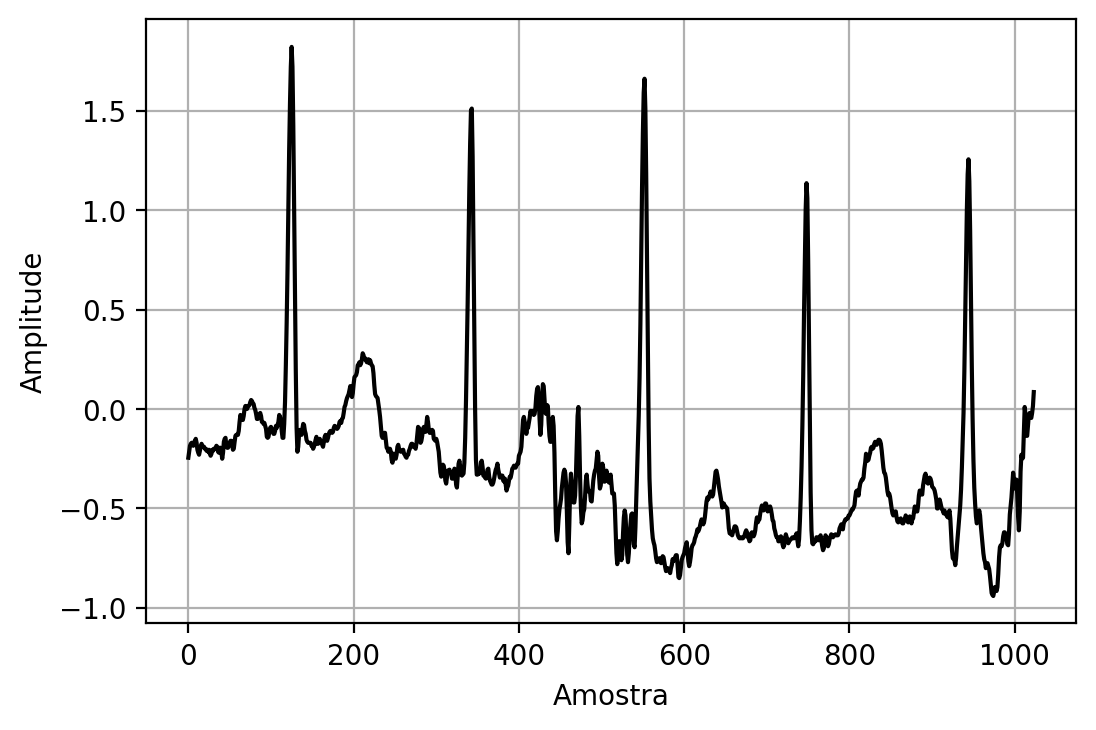

In [3]:
import matplotlib.pylab as pl
import scipy.io
from scipy.misc import electrocardiogram

''' 
Lê um sinal de ECG amostrado a 360Hz
Trunca para um tamanho de 1024
Lembrando que o comprimento deve ser divisível por 2^L
'''
ecg = electrocardiogram()[0:1024]

pl.figure(dpi=200)
pl.plot(ecg, color='black')
pl.xlabel('Amostra')
pl.ylabel('Amplitude')
pl.grid()

In [38]:
'''
Análise do sinal de ECG no nível máximo de resolução
'''
msvd = MRSVD()
Phi, Psi, Mu, U, S = msvd.dec(ecg, mean_removal=False)

print('Níveis de decomposição: %i\n' %msvd.max_level)

print('Energia sinal de ECG: %.4f\n' %np.sum(ecg**2))

print('Energia das componentes:\n')

for i in range(0, len(Phi)):

    #Calcula a energia total
    et = S[i][0]**2 + S[i][1]**2

    #Calcula a energia de cada componente
    print('Nível %i' %(i + 1))
    print('\tAproximação: %.4f' %S[i][0]**2)
    print('\tDetalhe: %.4f' %S[i][1]**2)
    print('\tTotal: %.4f' %et)
    print('\n')

Níveis de decomposição: 9

Energia sinal de ECG: 242.5090

Energia das componentes:

Nível 1
	Aproximação: 240.8587
	Detalhe: 1.6503
	Total: 242.5090


Nível 2
	Aproximação: 235.0019
	Detalhe: 5.8568
	Total: 240.8587


Nível 3
	Aproximação: 217.3945
	Detalhe: 17.6074
	Total: 235.0019


Nível 4
	Aproximação: 192.1487
	Detalhe: 25.2458
	Total: 217.3945


Nível 5
	Aproximação: 157.9044
	Detalhe: 34.2443
	Total: 192.1487


Nível 6
	Aproximação: 141.9866
	Detalhe: 15.9179
	Total: 157.9044


Nível 7
	Aproximação: 133.6094
	Detalhe: 8.3772
	Total: 141.9866


Nível 8
	Aproximação: 131.7584
	Detalhe: 1.8510
	Total: 133.6094


Nível 9
	Aproximação: 126.9617
	Detalhe: 4.7967
	Total: 131.7584




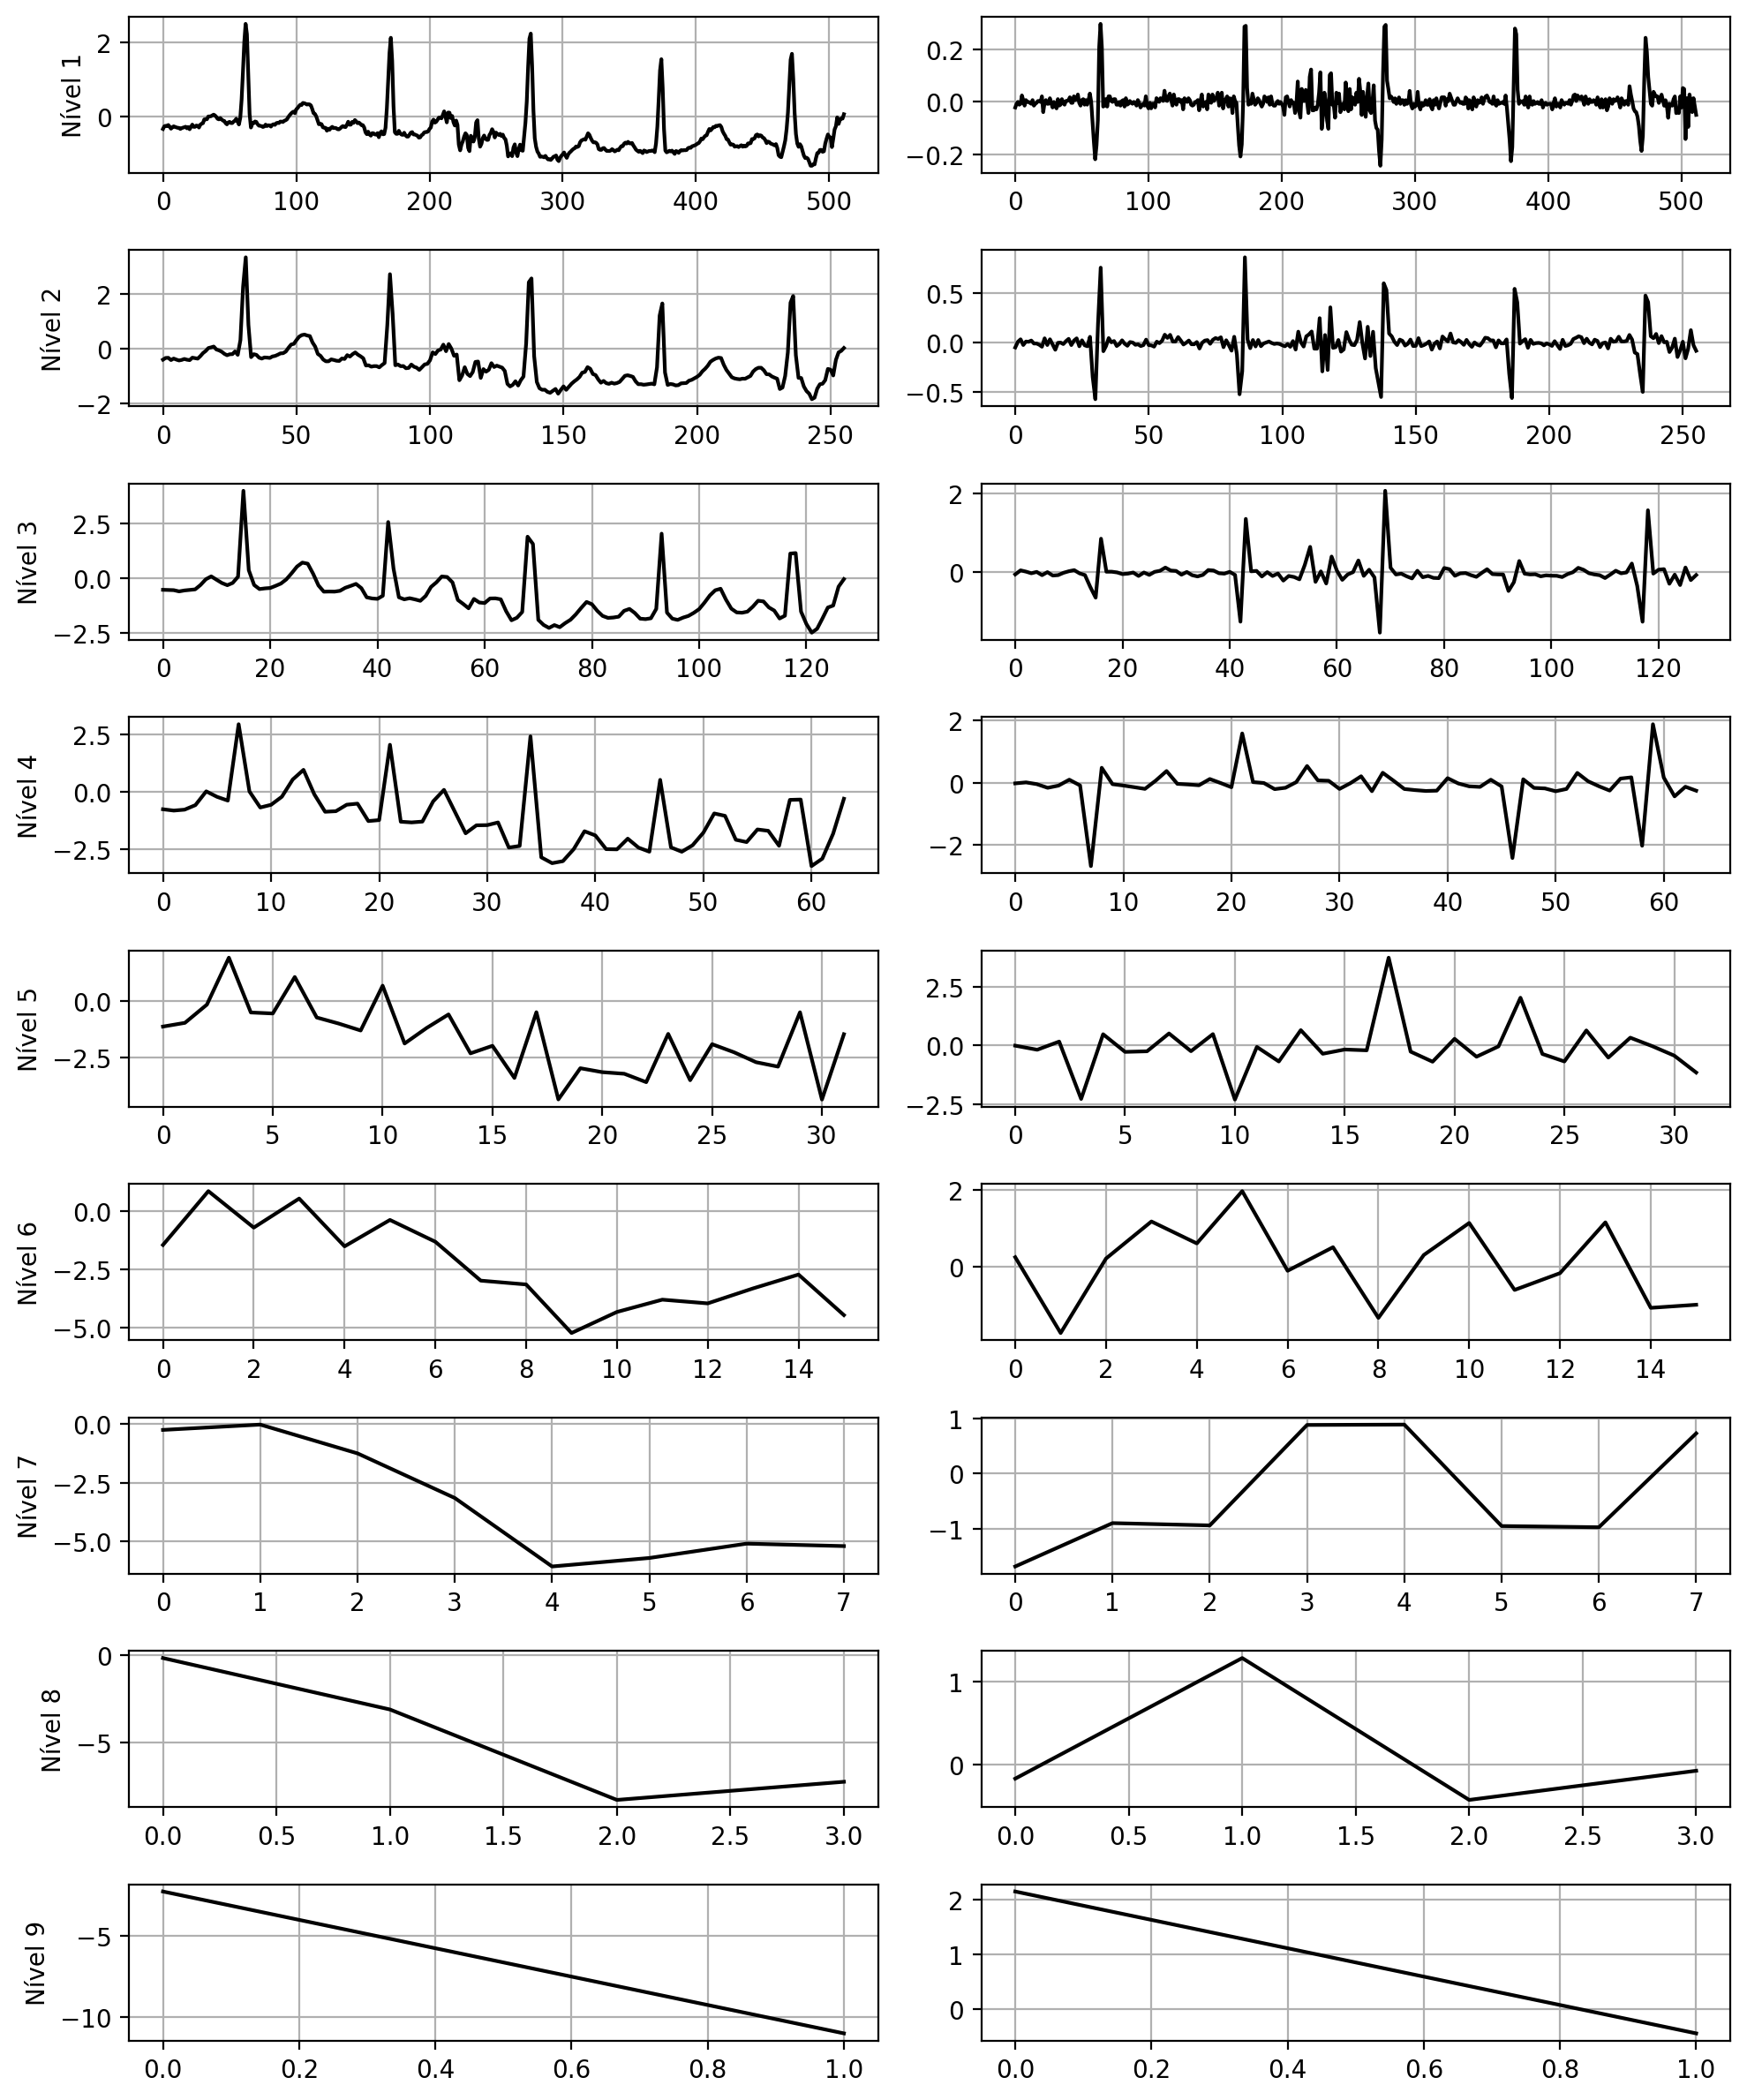

In [39]:
#Mostra o resultado
fig = pl.figure(dpi=200, figsize=(10,12))

j = 1
for i in range(0, msvd.max_level):
    pl.subplot(msvd.max_level, 2, j)
    pl.plot(Phi[i])
    pl.grid()
    pl.ylabel('Nível ' + str(i + 1))
    pl.subplot(msvd.max_level, 2, j + 1)
    pl.plot(Psi[i])
    pl.grid()
    j += 2

#Tira os números dos eixos
for ax in fig.get_axes():    
    #Deixa o grafico preto
    for line in ax.get_lines():
        line.set_color('black')

pl.tight_layout()
pl.show()

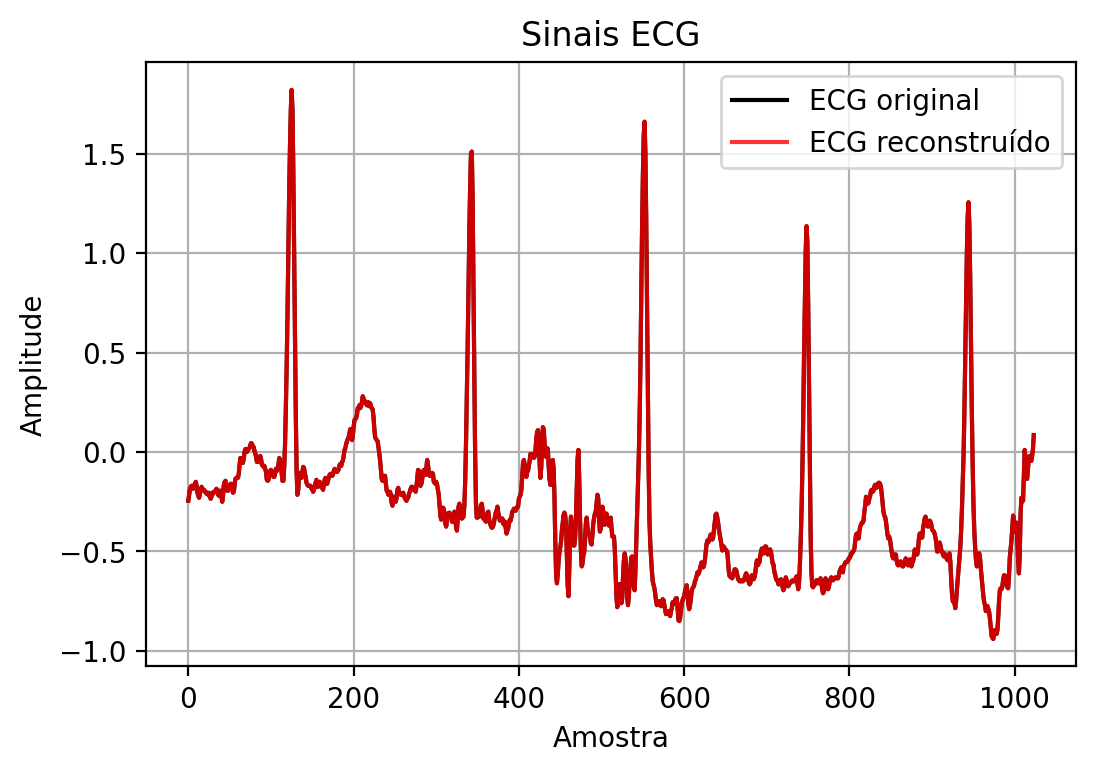

Erro de reconstrução: 0.0000000000


In [40]:
'''
Síntese do sinal de ECG
'''
ecg_ = msvd.rec(Phi, Psi, Mu, U)

pl.figure(dpi=200)
pl.plot(ecg, color='black', label='ECG original')
pl.plot(ecg_, color='red', label='ECG reconstruído', alpha=0.8)
pl.title('Sinais ECG')
pl.xlabel('Amostra')
pl.ylabel('Amplitude')
pl.grid()
pl.legend()

pl.show()

print('Erro de reconstrução: %.10f' %np.sum(ecg - ecg_))

<u>**Exemplo 4:** Remoção de ruído do sinal de ECG</u>

Utiliza o método denominado de limiarização proposta para a Transformada Wavelet Discreta, utilizando um limiar duro (hard threshold), que consiste em zerar os coeficientes $w_i$ que são menores que $|λ|$, onde $λ$ é um limiar calculado como

$$
λ = σ \sqrt{2 \log N}
$$

onde $σ$ é o desvio-padrão do ruído, e manter os coeficientes que são maiores.


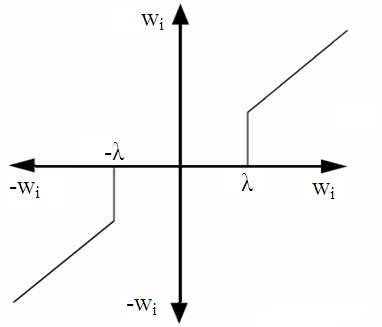

In [42]:
'''
Limiarização Hard nas componentes de detalhes
'''

#Estima o perfil do ruído, como as amostras iniciais do ECG
noise = ecg[0:110]

#calcula o limiar
lamb = np.std(noise) * np.sqrt(2 * np.log(len(ecg)))

#Aplica o limiar aos coeficientes de detalhes
#encolhendo (atenuando) aqueles que estão abaixo do limiar
Psi_ = []
for psi in Psi:
    psi_ = []
    for p in psi:
        if np.abs(p) <= lamb:
            psi_.append(0)
        else:
            psi_.append(p)
            
    Psi_.append(psi_)

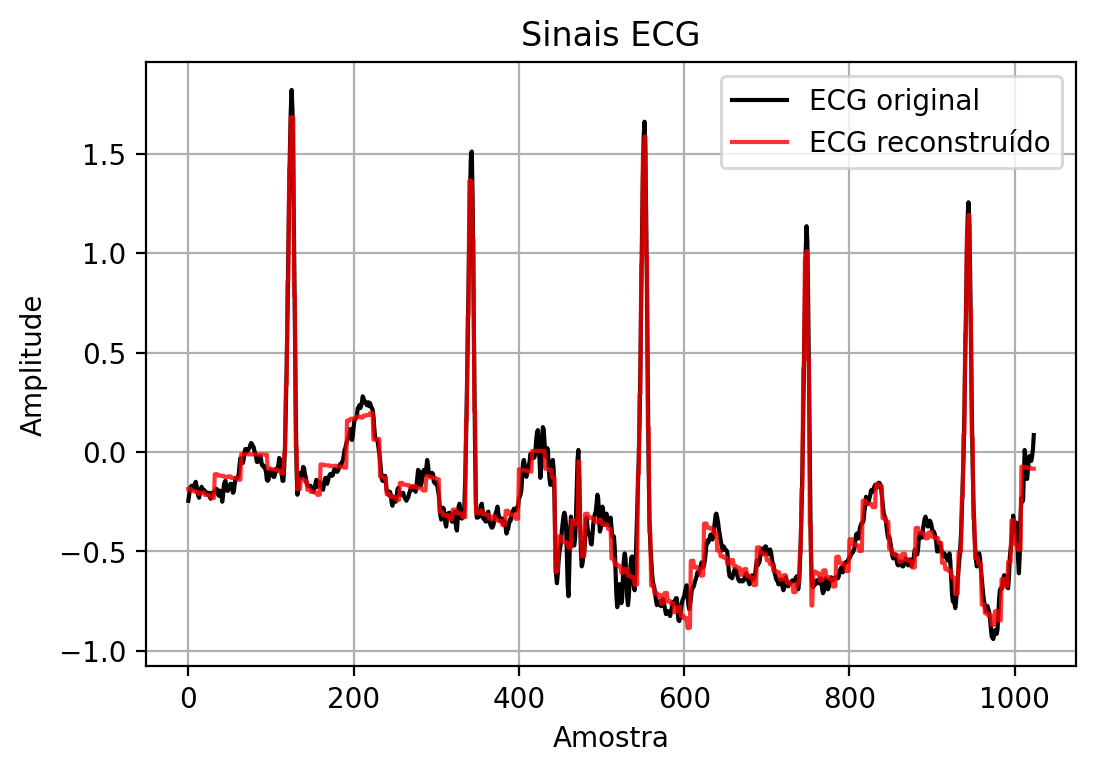

In [43]:
'''
Sintetiza um sinal de ECG com os coeficientes de detalhes atenuados
'''
ecg_ = msvd.rec(Phi, Psi_, Mu, U)

pl.figure(dpi=200)
pl.plot(ecg, color='black', label='ECG original')
pl.plot(ecg_, color='red', label='ECG reconstruído', alpha=0.8)
pl.title('Sinais ECG')
pl.xlabel('Amostra')
pl.ylabel('Amplitude')
pl.grid()
pl.legend()

pl.show()

<u>**Exemplo 5:** Remoção de ruído em frequência específica (60Hz)</u>

O sinal de ECG foi amostrado a 360Hz. Devido ao Teorema de Nyquist, e a subsmostragem da MRSVD teremos a seguinte divisão de frequências:

<table>
<tr><td>Nível</td><td>Aproximação</td><td>Detalhes</td></tr>
<tr><td>1</td><td>[0, 90]</td><td>[90, 180]</td></tr>
<tr><td>2</td><td>[0, 45]</td><td>[45, 90]</td></tr>
<tr><td>3</td><td>[0, 22.5]</td><td>[22.5, 45]</td></tr>
</table>

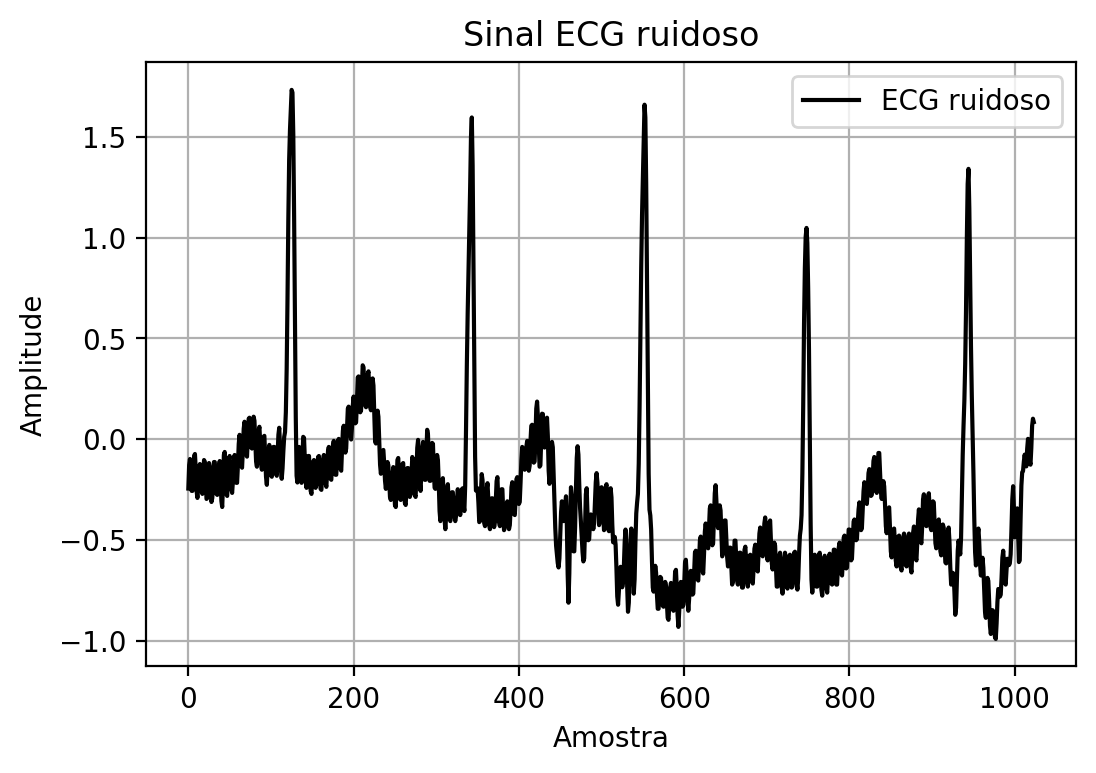

In [44]:
'''
Adiciona um ruído de 60Hz ao sinal de ECG
'''

t      = np.arange(0, len(ecg)/360, 1/360)
ecg_60 = ecg + np.sin(2 * np.pi * 60 * t) * 0.1

pl.figure(dpi=200)
pl.plot(ecg_60, color='black', label='ECG ruidoso')
pl.title('Sinal ECG ruidoso')
pl.xlabel('Amostra')
pl.ylabel('Amplitude')
pl.grid()
pl.legend()

pl.show()

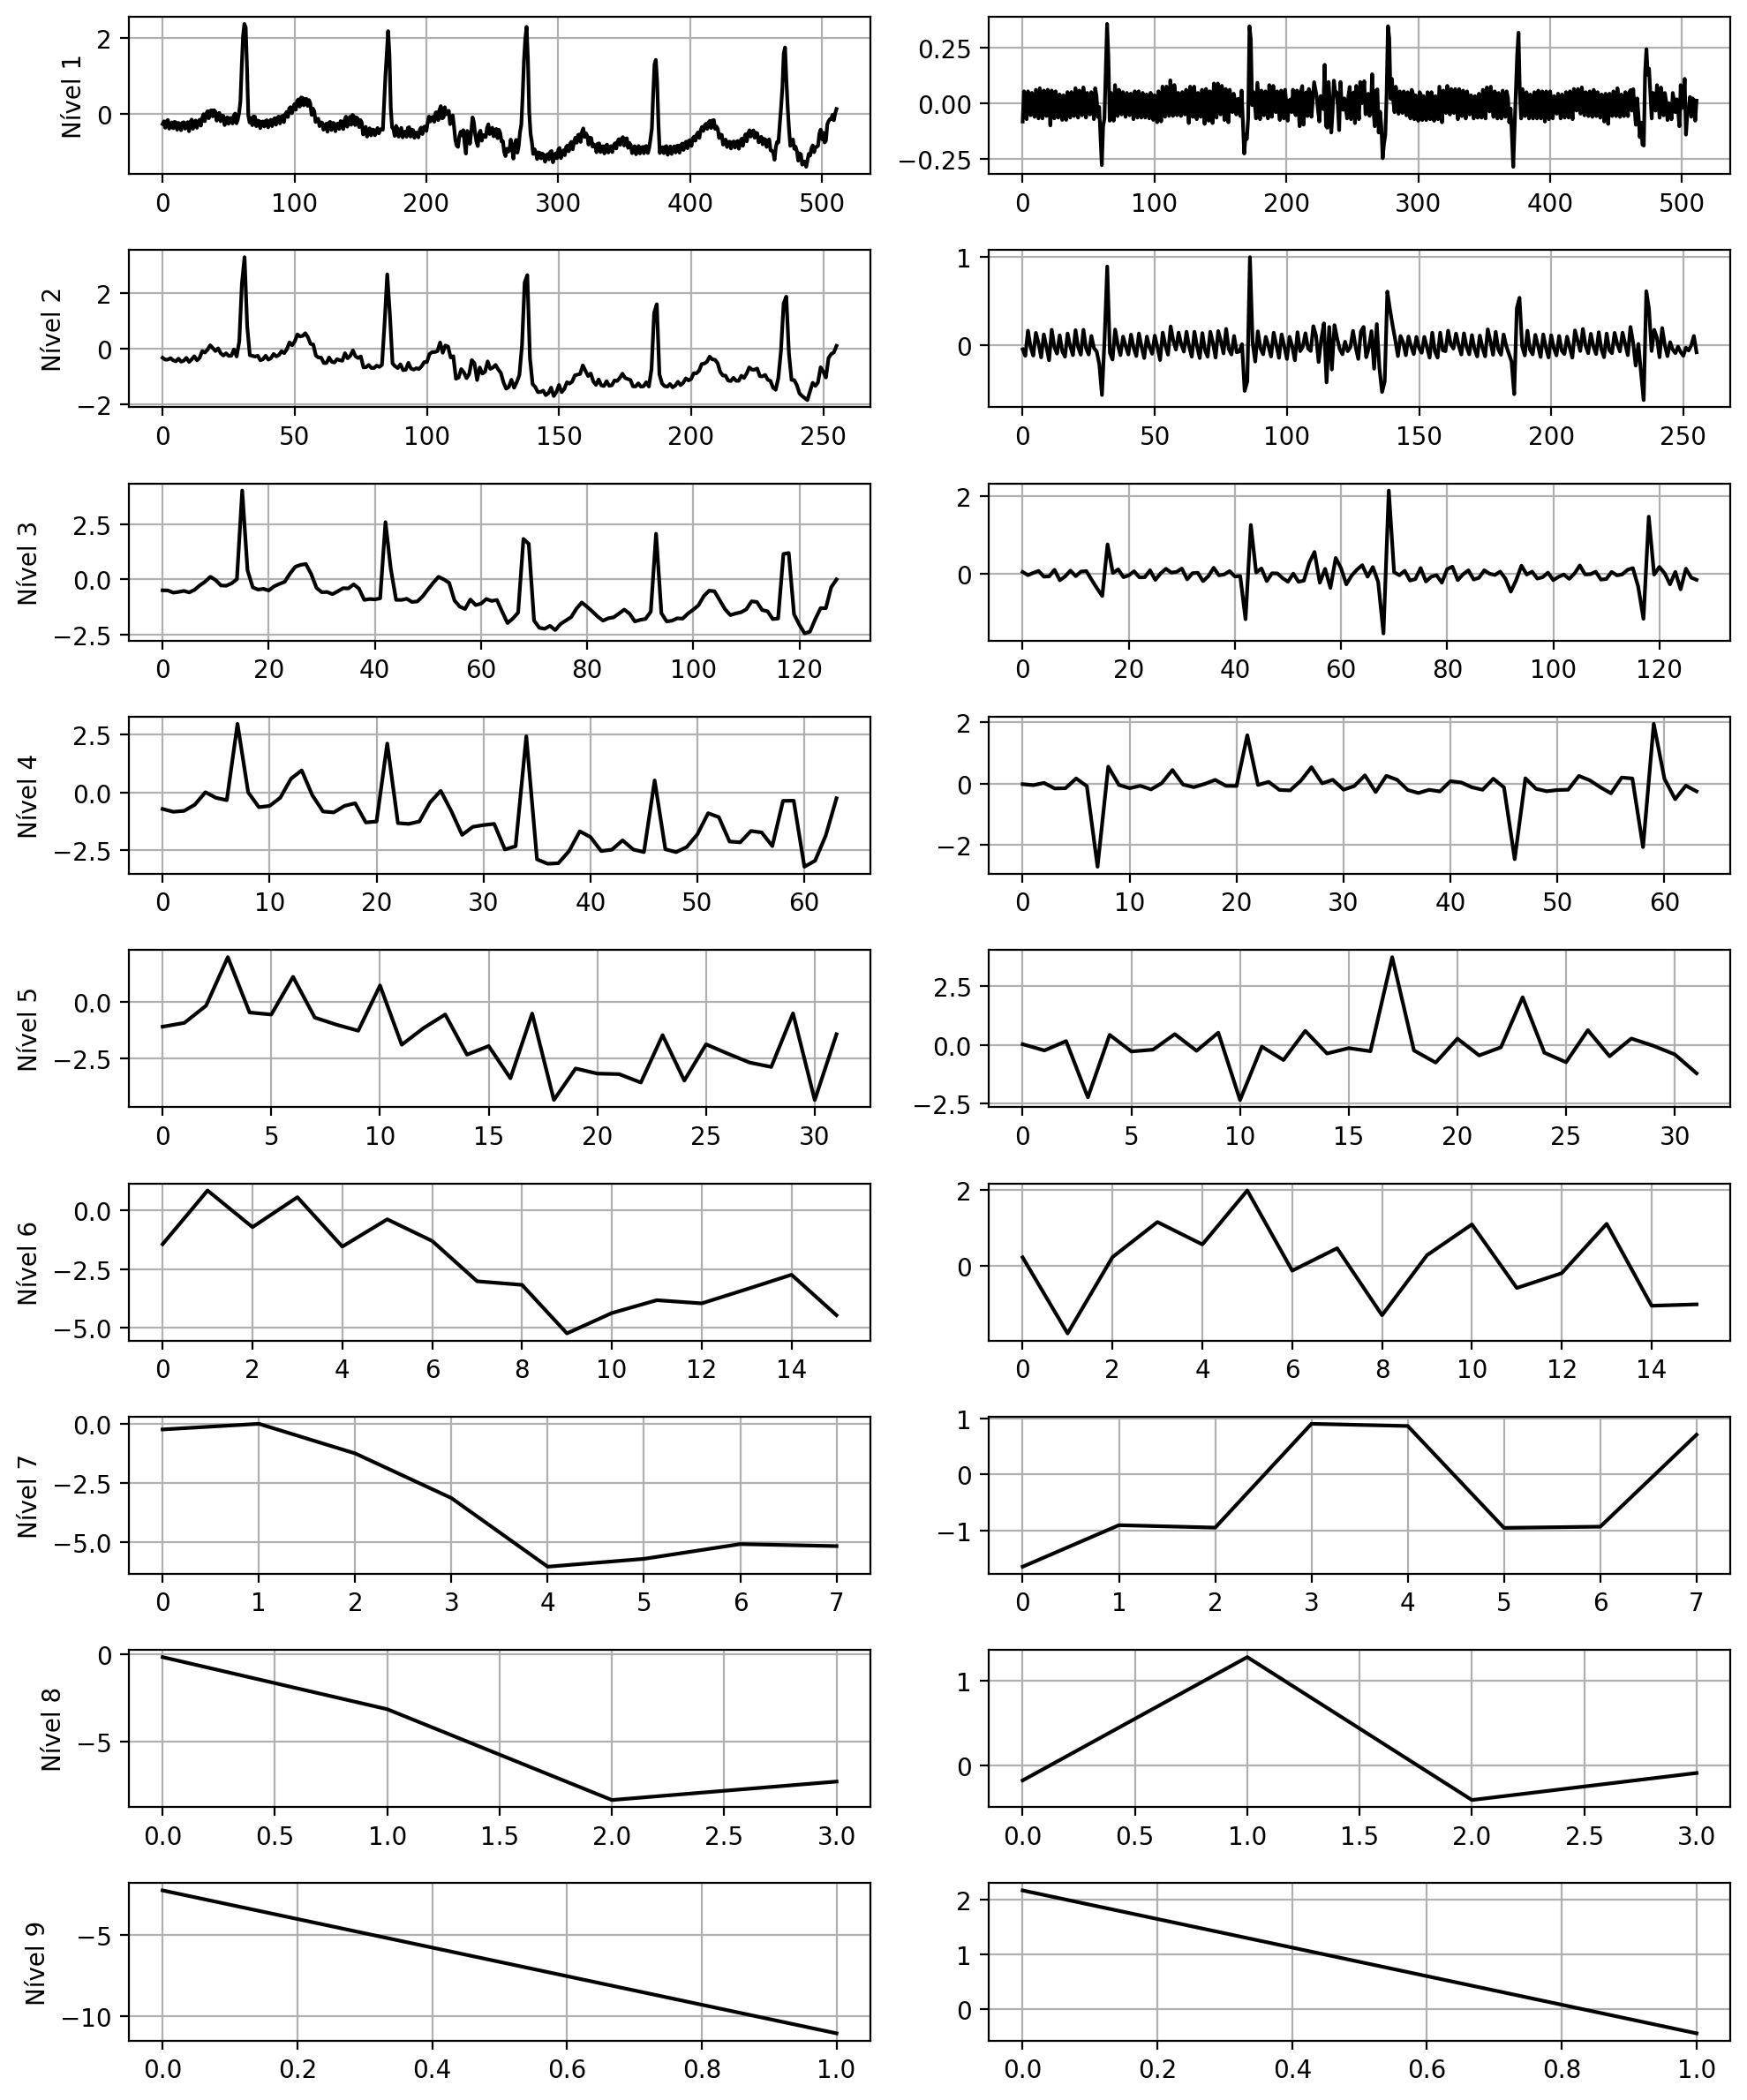

In [45]:
'''
Análise do sinal de ECG no nível máximo de resolução
'''
msvd = MRSVD()
Phi, Psi, Mu, U, S = msvd.dec(ecg_60, mean_removal=False)

#Mostra o resultado
fig = pl.figure(dpi=200, figsize=(10,12))

j = 1
for i in range(0, msvd.max_level):
    pl.subplot(msvd.max_level, 2, j)
    pl.plot(Phi[i])
    pl.grid()
    pl.ylabel('Nível ' + str(i + 1))
    pl.subplot(msvd.max_level, 2, j + 1)
    pl.plot(Psi[i])
    pl.grid()
    j += 2

#Tira os números dos eixos
for ax in fig.get_axes():    
    #Deixa o grafico preto
    for line in ax.get_lines():
        line.set_color('black')

pl.tight_layout()
pl.show()

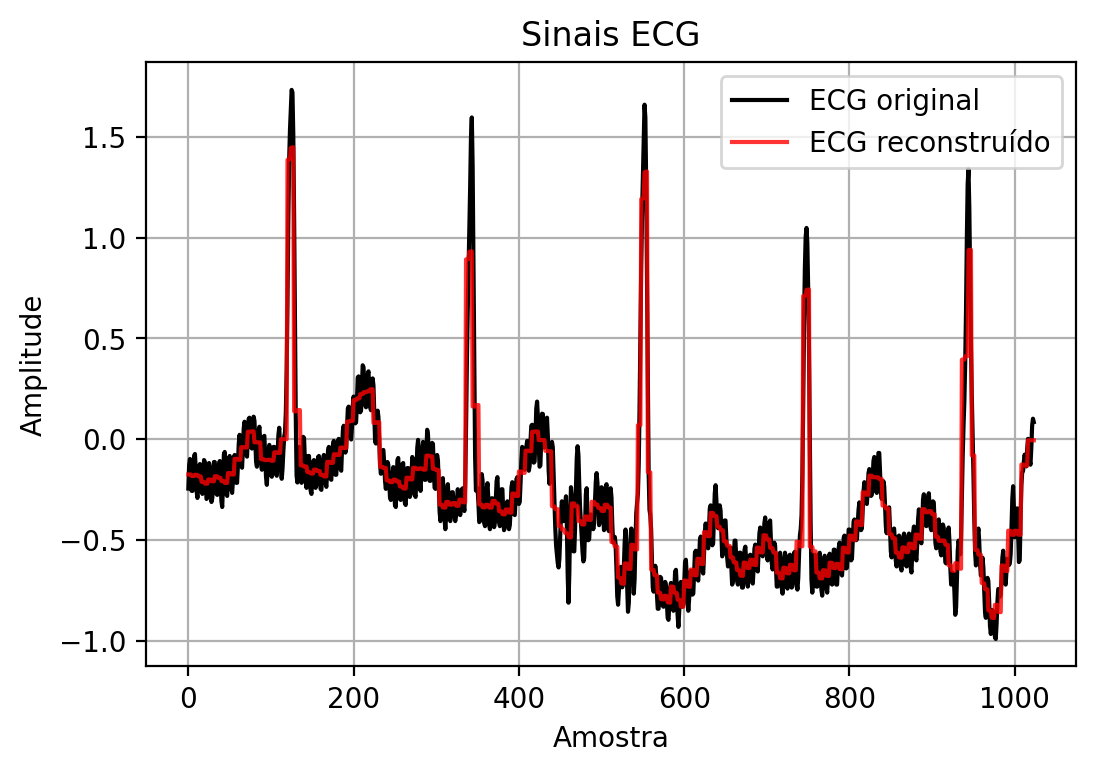

In [47]:
'''
Limiarização Hard nas componentes de detalhes dos Níveis 1 e 2 apenas
'''

#Estima o perfinal do ruído, como as amostras iniciais do ECG
noise = ecg[0:150]

#calcula o limiar
lamb = np.std(noise) * np.sqrt(2 * np.log(len(ecg)))

#Aplica o limiar aos coeficientes de detalhes
#encolhendo (atenuando) aqueles que estão abaixo do limiar
Psi_ = Psi[:]
for K in [0, 1, 2]:
    psi_ = []
    for p in Psi_[K]:
        if np.abs(p) <= lamb:
            psi_.append(0)
        else:
            psi_.append(p)
            
    Psi_[K] = psi_

#Reconstroi o sinal
ecg_60_ = msvd.rec(Phi, Psi_, Mu, U)

pl.figure(dpi=200)
pl.plot(ecg_60, color='black', label='ECG original')
pl.plot(ecg_60_, color='red', label='ECG reconstruído', alpha=0.8)
pl.title('Sinais ECG')
pl.xlabel('Amostra')
pl.ylabel('Amplitude')
pl.grid()
pl.legend()

pl.show()